# 【A/B测试】支付宝营销策略效果分析

Programmer: Dan.Q  
Date: 2020.06.25

A/B测试常用于比较不同设计、运营方案的优劣，以辅助决策。本分析以支付宝营销活动为例，通过广告点击率指标比较两组营销策略的广告投放效果。

## 1. 数据来源

本文所用数据集来自阿里云天池：  
[阿里云天池 - Audience Expansion Dataset](https://tianchi.aliyun.com/dataset/dataDetail?dataId=50893&lang=zh-cn)

该数据集包含三张表，分别记录了支付宝两组营销策略的活动情况：
* emb_tb_2.csv: 用户特征数据集
* effect_tb.csv: 广告点击情况数据集
* seed_cand_tb.csv: 用户类型数据集

本分析报告主要使用广告点击情况数据，涉及字段如下：

* dmp_id：营销策略编号（源数据文档未作说明，这里根据数据情况设定为1：对照组，2：营销策略一，3：营销策略二）
* user_id：支付宝用户ID
* label：用户当天是否点击活动广告（0：未点击，1：点击）

## 2. 数据处理

### 2.1 数据导入和清洗

#### 1. 整合表

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
# load data
data = pd.read_csv('data/effect_tb.csv',header = None)
data.columns = ["dt","user_id","label","dmp_id"]

# 日志天数属性用不上，删除该列
data = data.drop(columns = "dt")
data.head(3)

,user_id,label,dmp_id
0,1,0,1
1,1000004,0,1
2,1000004,0,2


In [26]:
# table summary
data.describe()

,user_id,label,dmp_id
count,2.645958e+06,2.645958e+06,2.645958e+06
mean,3.112995e+06,1.456297e-02,1.395761e+00
std,1.828262e+06,1.197952e-01,6.920480e-01
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.526772e+06,0.000000e+00,1.000000e+00
50%,3.062184e+06,0.000000e+00,1.000000e+00
75%,4.721132e+06,0.000000e+00,2.000000e+00
max,6.265402e+06,1.000000e+00,3.000000e+00


#### 2. 重复值处理

In [27]:
# shape of df
data.shape

(2645958, 3)

In [28]:
# distinct count of columns
data.nunique()

user_id    2410683
label            2
dmp_id           3
dtype: int64

数据行数与独立用户数不统一，检查是否存在重复行：

In [33]:
data[data.duplicated(keep = False)].sort_values(by = ["user_id"])

,user_id,label,dmp_id
8529,1027,0,1
1485546,1027,0,1
1579415,1471,0,1
127827,1471,0,1
404862,2468,0,1
...,...,...,...
1382121,6264633,0,1
1382245,6264940,0,1
2575140,6264940,0,1
1382306,6265082,0,3


In [34]:
# drop duplicate
data = data.drop_duplicates()

# check if any duplicates left
data[data.duplicated(keep = False)]

,user_id,label,dmp_id


#### 3. 空值处理

In [35]:
# check null values
data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2632975 entries, 0 to 2645957
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   user_id  2632975 non-null  int64
 1   label    2632975 non-null  int64
 2   dmp_id   2632975 non-null  int64
dtypes: int64(3)
memory usage: 80.4 MB


数据集无空值，无需进行处理。

#### 4. 异常值检查

通过透视表检查各属性字段是否存在不合理取值：

In [36]:
data.pivot_table(index = "dmp_id", columns = "label", values = "user_id",
                aggfunc = "count", margins = True)

label,0,1,All
dmp_id,,,
1,1881745,23918,1905663
2,404811,6296,411107
3,307923,8282,316205
All,2594479,38496,2632975


属性字段未发现异常取值，无需进行处理。

#### 5. 数据类型

In [37]:
data.dtypes

user_id    int64
label      int64
dmp_id     int64
dtype: object

数据类型正常，无需处理。

### 2.2 样本容量检验

在进行A/B测试前，需检查样本容量是否满足试验所需最小值。  
这里借助Evan Miller的样本量计算工具：  
[Sample Size Calculator](https://www.evanmiller.org/ab-testing/sample-size.html)  

首先需要设定点击率基准线以及最小提升比例，我们将对照组的点击率设为基准线.

In [38]:
# click rate of control group
data[data["dmp_id"] == 1]["label"].mean()

0.012551012429794775

对照组点击率为1.26%，假定我们希望新的营销策略能让广告点击率至少提升1个百分点，则算得所需最小样本量为：2167。
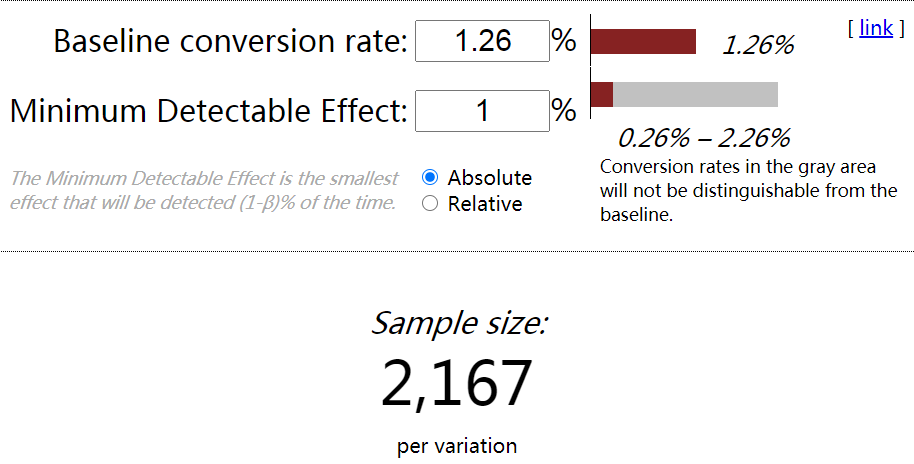

In [39]:
# sample size of campaigns
data["dmp_id"].value_counts()

1    1905663
2     411107
3     316205
Name: dmp_id, dtype: int64

两组营销活动的样本量分别为41.11万和31.62万，满足最小样本量需求。

In [40]:
# 保存清洗好的数据备用
# save it to file
data.to_csv("data/output.csv", index = False)

# reload data
# data = pd.read_csv("data/output.csv")

## 3. 假设检验

先观察几组试验的点击率情况。

In [41]:
# click rate of groups
print("对  照  组： " ,data[data["dmp_id"] == 1]["label"].mean())
print("营销策略一： " ,data[data["dmp_id"] == 2]["label"].mean())
print("营销策略二： " ,data[data["dmp_id"] == 3]["label"].mean())

对  照  组：  0.012551012429794775
营销策略一：  0.015314747742072015
营销策略二：  0.026191869198779274


可以看到策略一和策略二相较对照组在点击率上都有不同程度提升。  
其中策略一提升0.2个百分点，策略二提升1.3个百分点，只有策略二满足了前面我们对点击率提升最小值的要求。

接下来需要进行假设检验，看策略二点击率的提升是否显著。

**a. 零假设和备择假设**  
记对照组点击率为p1，策略二点击率为p2，则：  
零假设 H0： p1 ≥ p2  
备择假设 H1： p1 ＜ p2

**b. 分布类型、检验类型和显著性水平**  
样本服从二点分布，独立双样本，样本大小n＞30，总体均值和标准差未知，所以采用Z检验。显著性水平α取0.05。

### 3.1 方法一：公式计算

In [42]:
# 用户数
n_old = len(data[data.dmp_id == 1])  # 对照组
n_new = len(data[data.dmp_id == 3])  # 策略二

# 点击数
c_old = len(data[data.dmp_id ==1][data.label == 1])
c_new = len(data[data.dmp_id ==3][data.label == 1])

# 计算点击率
r_old = c_old / n_old
r_new = c_new / n_new

# 总和点击率
r = (c_old + c_new) / (n_old + n_new)

print("总和点击率：", r)

<ipython-input-42-dfc782d19ecb>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c_old = len(data[data.dmp_id ==1][data.label == 1])


总和点击率： 0.014492310074225832


<ipython-input-42-dfc782d19ecb>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c_new = len(data[data.dmp_id ==3][data.label == 1])


In [43]:
# 计算检验统计量z
z = (r_old - r_new) / np.sqrt(r * (1 - r)*(1/n_old + 1/n_new))

print("检验统计量z：", z)

检验统计量z： -59.44168632985996


In [44]:
# 查α=0.05对应的z分位数
from scipy.stats import norm
z_alpha = norm.ppf(0.05)
z_alpha

-1.6448536269514729

z_alpha = -1.64， 检验统计量z = -59.44，该检验为左侧单尾检验，拒绝域为{z＜z_alpha}。  
所以我们可以得出结论：原假设不成立，策略二点击率的提升在统计上是显著的。

### 3.2 方法二：Python函数计算
直接用python statsmodels包计算z值和p值。

In [45]:
import statsmodels.stats.proportion as sp
z_score, p = sp.proportions_ztest([c_old, c_new],[n_old, n_new], alternative = "smaller")
print("检验统计量z：",z_score,"，p值：", p)

检验统计量z： -59.44168632985996 ，p值： 0.0


p值约等于0，p ＜ α，与方法一结论相同，拒绝原假设。  

作为补充，我们再检验下策略一的点击率提升是否显著。

In [46]:
# 策略一检验
z_score, p = sp.proportions_ztest([c_old, len(data[data.dmp_id ==2][data.label == 1])],[n_old, len(data[data.dmp_id == 2])], alternative = "smaller")
print("检验统计量z：",z_score,"，p值：", p)

检验统计量z： -14.165873564308429 ，p值： 7.450121742737582e-46


<ipython-input-46-866f7bee4cd0>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z_score, p = sp.proportions_ztest([c_old, len(data[data.dmp_id ==2][data.label == 1])],[n_old, len(data[data.dmp_id == 2])], alternative = "smaller")


p值约等于7.45，p ＞ α，无法拒绝原假设，策略一对广告点击率的提升效果不显著。

## 4. 结论

综上所述，两种营销策略中，只有策略二对广告点击率有显著提升效果，相较于对照组点击率提升了近一倍，因而在两组营销策略中应选择第二组进行推广。

## 参考文档

* [一文入门A/B测试（含流程、原理及示例）](https://zhuanlan.zhihu.com/p/68019926)
* [Analyse ab testing results](https://www.kesci.com/home/project/5b98bf650cfcbf001030dc6a)